# Assignment 2 - 1BM110 - Data Driven AI - Group 30

Stef Knoben - 1451111 <br>
Mauro Colpaert - 1452584 <br>
Noa Vogel - 1621602 <br>
Nadieh Nijenhuis - 1304259 <br>

## Introduction

In this report the energy generated by onshore wind farms for each day from September 2023 until February 2024 will be predicted. Two different apporoaches will be used to model this problem.

## Questions

In [95]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import ruptures as rpt

### Model A

First, the dataset needs to be loaded. This is done in the following line.

In [70]:
df = pd.read_csv('energy_generation_train.csv')

In [73]:
to_drop = df.columns[df.isin([0, np.nan]).all()]
df_cleaned = df.drop(columns=to_drop)
df_cleaned['DateTime'] = pd.to_datetime(df_cleaned['DateTime'])
print(df_cleaned.head())

             DateTime  Fossil Gas  Fossil Hard coal  Nuclear  Other  Solar  \
0 2022-08-04 00:15:00      5613.0            2747.0    466.0   79.0    0.0   
1 2022-08-04 00:30:00      5425.0            2742.0    464.0   86.0    0.0   
2 2022-08-04 00:45:00      5039.0            2797.0    464.0   90.0    0.0   
3 2022-08-04 01:00:00      4661.0            2805.0    464.0   92.0    0.0   
4 2022-08-04 01:15:00      3833.0            2789.0    464.0   91.0    0.0   

   Waste  Wind Offshore  Wind Onshore  
0   70.0          186.0          52.0  
1   70.0          210.0          62.0  
2   69.0          233.0          71.0  
3   69.0          245.0          75.0  
4   71.0          264.0          78.0  


#### A1. Data pre-processing

Missing values will be filled by the value of the quarter before. It is assumed the force of the wind will not change too much during 15 minutes, so the generated energy of the timeframe before is used as an estimation. This will result in a dataframe without missing values.

In [74]:
df_cleaned.fillna(method='ffill', inplace=True)
print(df_cleaned.head())

             DateTime  Fossil Gas  Fossil Hard coal  Nuclear  Other  Solar  \
0 2022-08-04 00:15:00      5613.0            2747.0    466.0   79.0    0.0   
1 2022-08-04 00:30:00      5425.0            2742.0    464.0   86.0    0.0   
2 2022-08-04 00:45:00      5039.0            2797.0    464.0   90.0    0.0   
3 2022-08-04 01:00:00      4661.0            2805.0    464.0   92.0    0.0   
4 2022-08-04 01:15:00      3833.0            2789.0    464.0   91.0    0.0   

   Waste  Wind Offshore  Wind Onshore  
0   70.0          186.0          52.0  
1   70.0          210.0          62.0  
2   69.0          233.0          71.0  
3   69.0          245.0          75.0  
4   71.0          264.0          78.0  


The total energy generated on a specific day is needed. The current data has the energy generated each quarter of an hour, so the data will be transformed to daily data. This will result in a dataframe with a specific day as the index, and the generated energy in the first column.

In [75]:
df_cleaned.set_index('DateTime', inplace=True)
df_perday = df_cleaned.resample('D').sum()
print(df_perday.head())

            Fossil Gas  Fossil Hard coal  Nuclear   Other   Solar   Waste  \
DateTime                                                                    
2022-08-04    358335.0          275667.0  44548.0  6679.0  2674.0  6430.0   
2022-08-05    230517.0          284465.0  44012.0  9076.0  3085.0  6814.0   
2022-08-06    172151.0          247908.0  43898.0  4161.0  3270.0  6926.0   
2022-08-07    169306.0          227736.0  43916.0  2652.0  3940.0  6871.0   
2022-08-08    226070.0          270330.0  44508.0  3493.0  2745.0  6780.0   

            Wind Offshore  Wind Onshore  
DateTime                                 
2022-08-04        17291.0        7603.0  
2022-08-05        32944.0       18493.0  
2022-08-06         8876.0        5874.0  
2022-08-07         6608.0        2544.0  
2022-08-08        13010.0        5455.0  


Next, outliers are found. This is visualized by creating a boxplot. The found outliers will be corrected to the closest upper-, or lower value in the boxplot. This is done so exceptionally windy, or exceptionally wind-still days are not influencing the prediction.

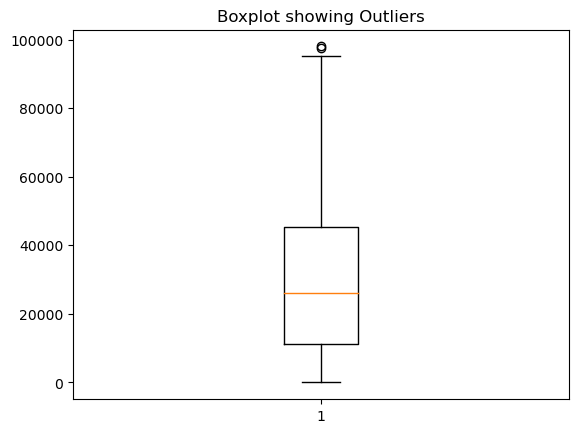

In [77]:
plt.boxplot(df_perday['Wind Onshore'])
plt.title('Boxplot showing Outliers')
plt.show()

Following from this, it can be seen that there are some outliers above the upper quartile. These will be replaced with the value of the upper quartile.

In [78]:
UV = df_perday['Wind Onshore'].quantile(0.99)
#print(UV)
df_perday.loc[df_perday['Wind Onshore'] > UV, 'Wind Onshore'] = UV

Next, the energy generated will be standardized. This will rescale the energy generated into a smaller scale using the Z-score normalization. The energy generated will be transformed to a value with mean 0 and standard deviation of 1, which will be usefull for learning algorithm. A new column will be added called 'Standardized Wind Onshore'.

In [80]:
scaler = StandardScaler()
column_data = df_perday['Wind Onshore'].values.reshape(-1, 1)
df_perday['Standardized Wind Onshore'] = scaler.fit_transform(column_data)
print(df_perday.head())

            Fossil Gas  Fossil Hard coal  Nuclear   Other   Solar   Waste  \
DateTime                                                                    
2022-08-04    358335.0          275667.0  44548.0  6679.0  2674.0  6430.0   
2022-08-05    230517.0          284465.0  44012.0  9076.0  3085.0  6814.0   
2022-08-06    172151.0          247908.0  43898.0  4161.0  3270.0  6926.0   
2022-08-07    169306.0          227736.0  43916.0  2652.0  3940.0  6871.0   
2022-08-08    226070.0          270330.0  44508.0  3493.0  2745.0  6780.0   

            Wind Offshore  Wind Onshore  Standardized Wind Onshore  
DateTime                                                            
2022-08-04        17291.0        7603.0                  -0.982832  
2022-08-05        32944.0       18493.0                  -0.541604  
2022-08-06         8876.0        5874.0                  -1.052886  
2022-08-07         6608.0        2544.0                  -1.187807  
2022-08-08        13010.0        5455.0       

### A2. Feature creation

#### A2 Feature creation involves 'part of the date' features (month, year, etc).

In [91]:
df_perday.reset_index(inplace=True)
df_perday['Day of month'] = df_perday['DateTime'].dt.day
df_perday['Month'] = df_perday['DateTime'].dt.month
df_perday['Week'] = df_perday['DateTime'].dt.isocalendar().week
df_perday

,index,DateTime,Fossil Gas,Fossil Hard coal,Nuclear,Other,Solar,Waste,Wind Offshore,Wind Onshore,Standardized Wind Onshore,Day of month,Month,Week,Season
0,0,2022-08-04,358335.0,275667.0,44548.0,6679.0,2674.0,6430.0,17291.0,7603.0,-0.982832,4,8,31,Summer
1,1,2022-08-05,230517.0,284465.0,44012.0,9076.0,3085.0,6814.0,32944.0,18493.0,-0.541604,5,8,31,Summer
2,2,2022-08-06,172151.0,247908.0,43898.0,4161.0,3270.0,6926.0,8876.0,5874.0,-1.052886,6,8,31,Summer
3,3,2022-08-07,169306.0,227736.0,43916.0,2652.0,3940.0,6871.0,6608.0,2544.0,-1.187807,7,8,31,Summer
4,4,2022-08-08,226070.0,270330.0,44508.0,3493.0,2745.0,6780.0,13010.0,5455.0,-1.069863,8,8,32,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,388,2023-08-27,456018.0,87204.0,44989.0,13369.0,3774.0,6681.0,76510.0,31206.0,-0.026513,27,8,34,Summer
389,389,2023-08-28,612967.0,87749.0,45019.0,32514.0,5914.0,6617.0,29281.0,10998.0,-0.845278,28,8,35,Summer
390,390,2023-08-29,752436.0,93925.0,45048.0,60689.0,4522.0,6617.0,20078.0,3457.0,-1.150815,29,8,35,Summer
391,391,2023-08-30,654361.0,62852.0,45082.0,22869.0,2408.0,6763.0,76323.0,28682.0,-0.128778,30,8,35,Summer


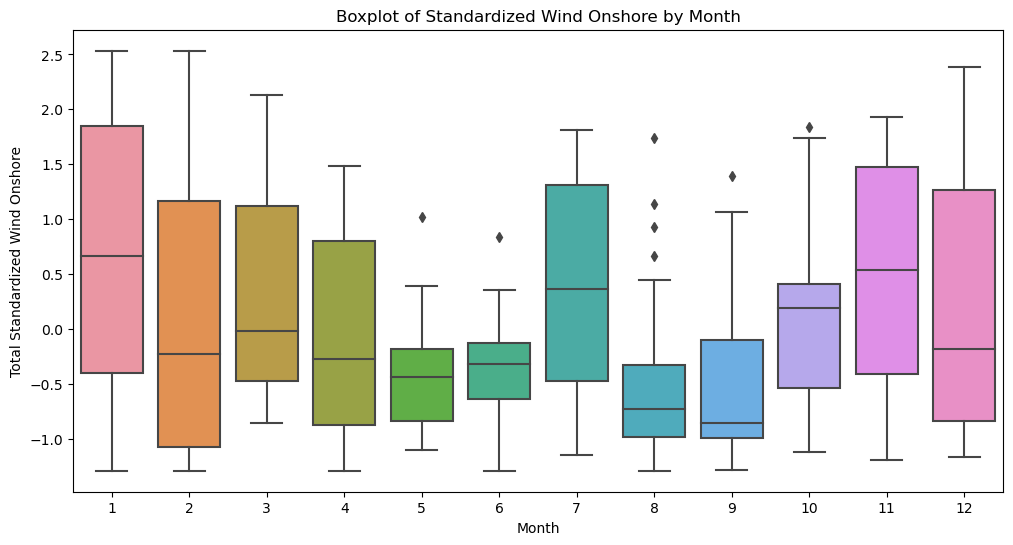

In [92]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Standardized Wind Onshore', data=df_perday)
plt.xlabel('Month')
plt.ylabel('Total Standardized Wind Onshore')
plt.title('Boxplot of Standardized Wind Onshore by Month')
plt.show()

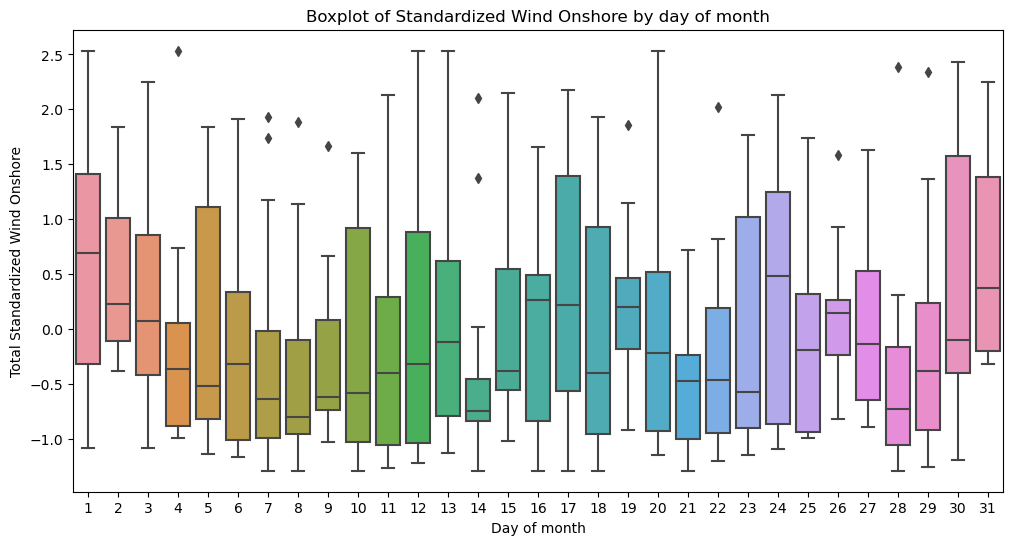

In [93]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day of month', y='Standardized Wind Onshore', data=df_perday)
plt.xlabel('Day of month')
plt.ylabel('Total Standardized Wind Onshore')
plt.title('Boxplot of Standardized Wind Onshore by day of month')
plt.show()

#### A2 Feature creation involves features based on the frequency distribution of the series (mean, median, etc).

In [94]:
df_monthly = df_perday.groupby('Month')['Standardized Wind Onshore'].agg(['min', 'max', 'mean', 'std', 'median'])
print(df_monthly)

            min       max      mean       std    median
Month                                                  
1     -1.290882  2.534020  0.687188  1.312203  0.666933
2     -1.290882  2.534020  0.151939  1.361774 -0.226464
3     -0.856136  2.129551  0.351967  0.990989 -0.018612
4     -1.290882  1.486913 -0.077525  0.879437 -0.274294
5     -1.098184  1.020119 -0.438560  0.497238 -0.434801
6     -1.290882  0.833174 -0.382228  0.477195 -0.318599
7     -1.151666  1.808698  0.404811  0.953931  0.359937
8     -1.290882  1.738726 -0.536839  0.630215 -0.731101
9     -1.286142  1.389754 -0.448904  0.781129 -0.855366
10    -1.124722  1.840788  0.082883  0.788463  0.194507
11    -1.191332  1.930613  0.534663  1.021923  0.534463
12    -1.163700  2.389913  0.158133  1.169786 -0.186230


The second one is created based on the season. This zooms out more compared to the month feature and can give more general insights.

In [85]:
#Deze denk ik weghalen omdat het niet een component van de "date" bevat.
def get_season(month):
    if 3 <= int(month) <= 5:
        return 'Spring'
    elif 6 <= int(month) <= 8:
        return 'Summer'
    elif 9 <= int(month) <= 11:
        return 'Fall'
    else:
        return 'Winter'
        
df_perday['Season'] = df_perday['Month'].apply(get_season)

df_season = df_perday.groupby('Season')['Standardized Wind Onshore'].agg(['min', 'max', 'mean', 'std', 'median'])
print(df_season)

             min       max      mean       std    median
Season                                                  
Fall   -1.286142  1.930613  0.056507  0.949703 -0.031497
Spring -1.290882  2.129551 -0.054458  0.870886 -0.286570
Summer -1.290882  1.808698 -0.254927  0.797091 -0.489013
Winter -1.290882  2.534020  0.338436  1.291850  0.157494


Next changepoints in the days will be found. This will be done to see if there is a clear moment when the wind generates more energy during the year, or to see if there is a clear moment when less energy is generated. These changepoints will be printed.

In [86]:
df_dayly = df_perday.groupby('Day of month')['Standardized Wind Onshore'].agg(['min', 'max', 'mean', 'std', 'median'])
print(df_dayly)

                   min       max      mean       std    median
Day of month                                                  
1            -1.085948  2.534020  0.586756  1.197579  0.694322
2            -0.383750  1.836128  0.473425  0.796531  0.231235
3            -1.080397  2.244862  0.325295  1.047379  0.075245
4            -0.991827  2.534020 -0.154631  0.957499 -0.360818
5            -1.137728  1.840788  0.093018  1.088194 -0.518631
6            -1.169372  1.916311 -0.087721  1.030730 -0.315398
7            -1.290882  1.930613 -0.229605  1.117409 -0.634023
8            -1.290882  1.880454 -0.382556  0.941278 -0.797630
9            -1.026023  1.666038 -0.283169  0.761868 -0.615547
10           -1.290882  1.606073 -0.105415  1.063281 -0.580014
11           -1.265194  2.128214 -0.158087  1.038152 -0.399268
12           -1.220869  2.534020 -0.078544  1.158725 -0.321800
13           -1.127275  2.534020  0.079248  1.180991 -0.118891
14           -1.290882  2.099002 -0.360765  0.998468 -0

In [87]:
print(df_perday.head()) #Season kan dus misschien weg

    DateTime  Fossil Gas  Fossil Hard coal  Nuclear   Other   Solar   Waste  \
0 2022-08-04    358335.0          275667.0  44548.0  6679.0  2674.0  6430.0   
1 2022-08-05    230517.0          284465.0  44012.0  9076.0  3085.0  6814.0   
2 2022-08-06    172151.0          247908.0  43898.0  4161.0  3270.0  6926.0   
3 2022-08-07    169306.0          227736.0  43916.0  2652.0  3940.0  6871.0   
4 2022-08-08    226070.0          270330.0  44508.0  3493.0  2745.0  6780.0   

   Wind Offshore  Wind Onshore  Standardized Wind Onshore  Day of month  \
0        17291.0        7603.0                  -0.982832             4   
1        32944.0       18493.0                  -0.541604             5   
2         8876.0        5874.0                  -1.052886             6   
3         6608.0        2544.0                  -1.187807             7   
4        13010.0        5455.0                  -1.069863             8   

   Month  Week  Season  
0      8    31  Summer  
1      8    31  Summer  